# Disorder maps

In [1]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
from gradientVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/plot_maps.R");

/opt/conda/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


---

In [3]:
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [4]:
dk_scores = dm_hcp_3d_ds5.score_in_dk()

In [ ]:
name = 'dm_hcp_3d_ds5_vertices'
n=5000
generate_spins_from_gradients(dk_scores, n=n, outfile=f'../outputs/permutations/spin_dk_{n}_{name}.npy', atlas='dk')
print(f'Made n={n} spins for {name}')

##### FC SCZ maps

Get disorder maps from Sarah

In [21]:
fnames = ["../data/scz_maps/scz.case.control.t.csv",
          "../data/scz_maps/scz.case.control.p.csv"]

maps = (pd.concat([pd.read_csv(fname, header=None) for fname in fnames], axis=1)
          .set_axis(['t', 'p'], axis=1)
          .loc[16:] # drop subcortex by Lena's advice
          .set_axis([i+1 for i in range(360)])
          .assign(label=get_labels_hcp())
          .loc[:180]
          .set_index('label')
          .apply(lambda x: (x-np.mean(x))/np.std(x))
)
maps

,t,p
label,,
V1,0.252906,-0.145496
MST,-0.288119,-0.146463
V6,-0.988564,-0.146578
V2,-0.093650,-0.146315
V3,0.387453,-0.144735
...,...,...
STSva,-1.222509,-0.146582
TE1m,1.153846,-0.113227
PI,-1.790872,-0.146584


In [12]:
dm_hcp_ds8 = gradientVersion().fit('hcp_ds8')
dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_ds8
New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [13]:
scores = dm_hcp_ds8.clean_scores()
nulls = np.load("../outputs/permutations/hcp_ds8_sim_1000.npy")

In [22]:
null_corrs = corr_nulls_from_grads(nulls, scores, maps)

In [23]:
corrs = get_corrs(scores, maps)
null_p = get_null_p(corrs, null_corrs, adjust='fdr_bh')

In [37]:
maps_scatter = (maps.loc[:,['t']]
                .melt(ignore_index=False, var_name='map', value_name='map_score')
                .join(scores.set_index('label')).reset_index()
                .set_index(['label','map','map_score'])
                .melt(ignore_index=False, var_name='G', value_name='G_score')
                .reset_index()
               )
maps_scatter_corrs = null_p.loc[:,['map','G','true_mean','p']].query("map=='t'")

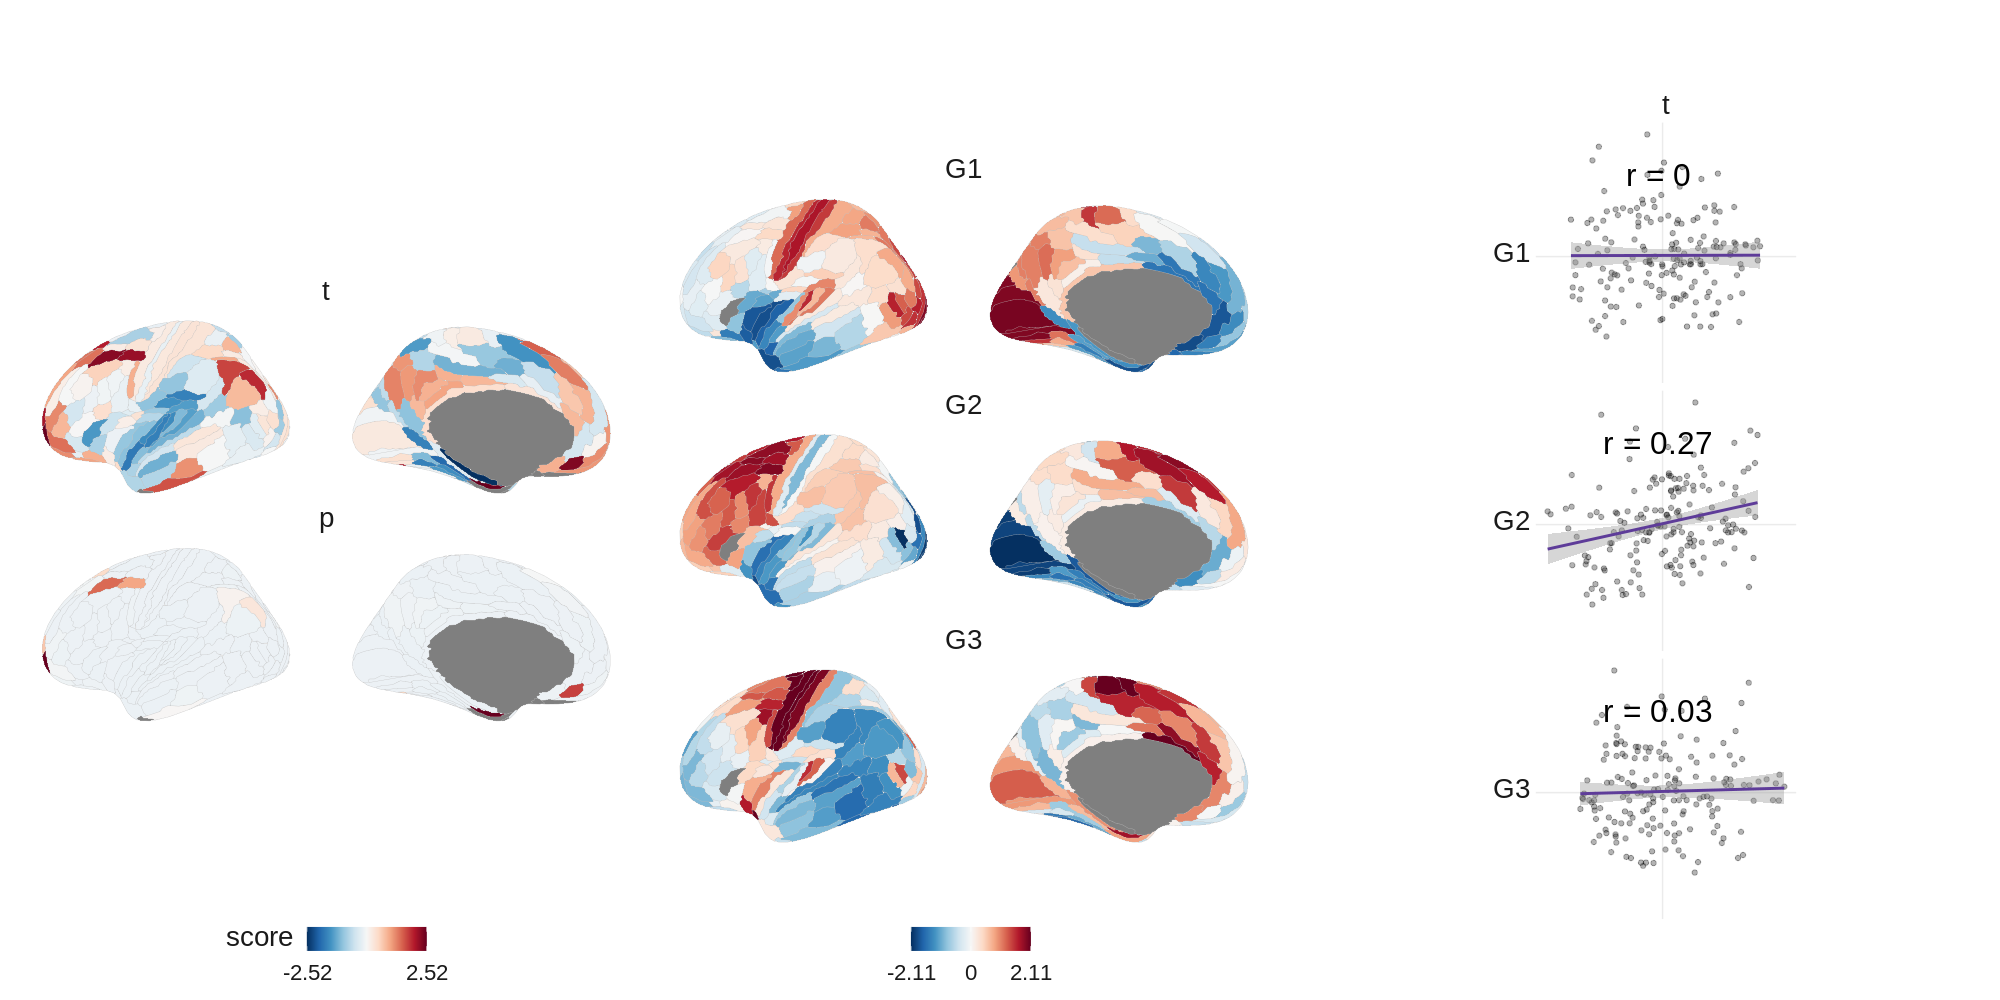

In [46]:
%%R -w 20 -h 10 --units in -r 100 -i maps -i scores -i null_p -i maps_scatter -i maps_scatter_corrs
source("../code/plot_maps.R")
g1 = plot_maps(maps, ncol=1, colors=rev(brewer.rdbu(100)))
g2 = plot_hcp(scores, facet='w')
g3 = plot_corr_versions(null_p %>% mutate(version='')) + scale_x_discrete(position='top') + 
    theme(axis.text=element_text(size=20,color='grey10'))
g4 = plot_maps_scatter(maps_scatter, maps_scatter_corrs %>% mutate(q=p), x=0,y=2,size=8,facet='h')

(g1 | g2 | g4) & 
theme(strip.text=element_text(size=20, color='grey10'),
                            text=element_text(size=20, color='grey10'))

## MSN SCZ maps

Get disorder maps from Sarah

In [39]:
fnames = ["../data/scz_maps/meantstat.dat",
          "../data/scz_maps/mytstat_HCP_Cobre.dat",
          "../data/scz_maps/mytstat_HCP_Dublin.dat",
          "../data/scz_maps/mytstat_HCP_Maast.dat"]

maps = (pd.concat([pd.Series(np.loadtxt(fname)) for fname in fnames], axis=1)
          .set_axis(['Mean', 'Cobre','Dublin','Maast'], axis=1)
          .set_axis([i+1 for i in range(360)])
          .assign(label=get_labels_hcp())
          .loc[:180]
          .set_index('label')
          .apply(lambda x: (x-np.mean(x))/np.std(x))
)
maps

,Mean,Cobre,Dublin,Maast
label,,,,
V1,0.903424,1.270471,0.608855,-0.282919
MST,1.893736,0.446206,1.838347,1.807922
V6,0.647147,0.791659,0.262124,0.304866
V2,1.057697,1.549445,0.780874,-0.554124
V3,1.280039,2.000149,0.779959,-0.558036
...,...,...,...,...
STSva,-0.979626,-0.346684,-0.769389,-1.092696
TE1m,-0.198817,-0.867596,-0.248744,1.189551
PI,-0.983860,-1.421400,-0.920037,0.844609


In [25]:
dm_hcp_ds8 = gradientVersion().fit('hcp_ds8')
dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_ds8
New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [68]:
scores = dm_hcp_ds8.clean_scores()
nulls = np.load("../outputs/permutations/hcp_ds8_sim_1000.npy")

In [69]:
null_corrs = corr_nulls_from_grads(nulls, scores, maps)

In [70]:
corrs = get_corrs(scores, maps)
null_p = get_null_p(corrs, null_corrs, adjust='fdr_bh')

In [71]:
maps_scatter = (maps
                .melt(ignore_index=False, var_name='map', value_name='map_score')
                .join(scores.set_index('label')).reset_index()
                .set_index(['label','map','map_score'])
                .melt(ignore_index=False, var_name='G', value_name='G_score')
                .reset_index()
               )
maps_scatter_corrs = (null_p.loc[:,['map','G','true_mean','p']])

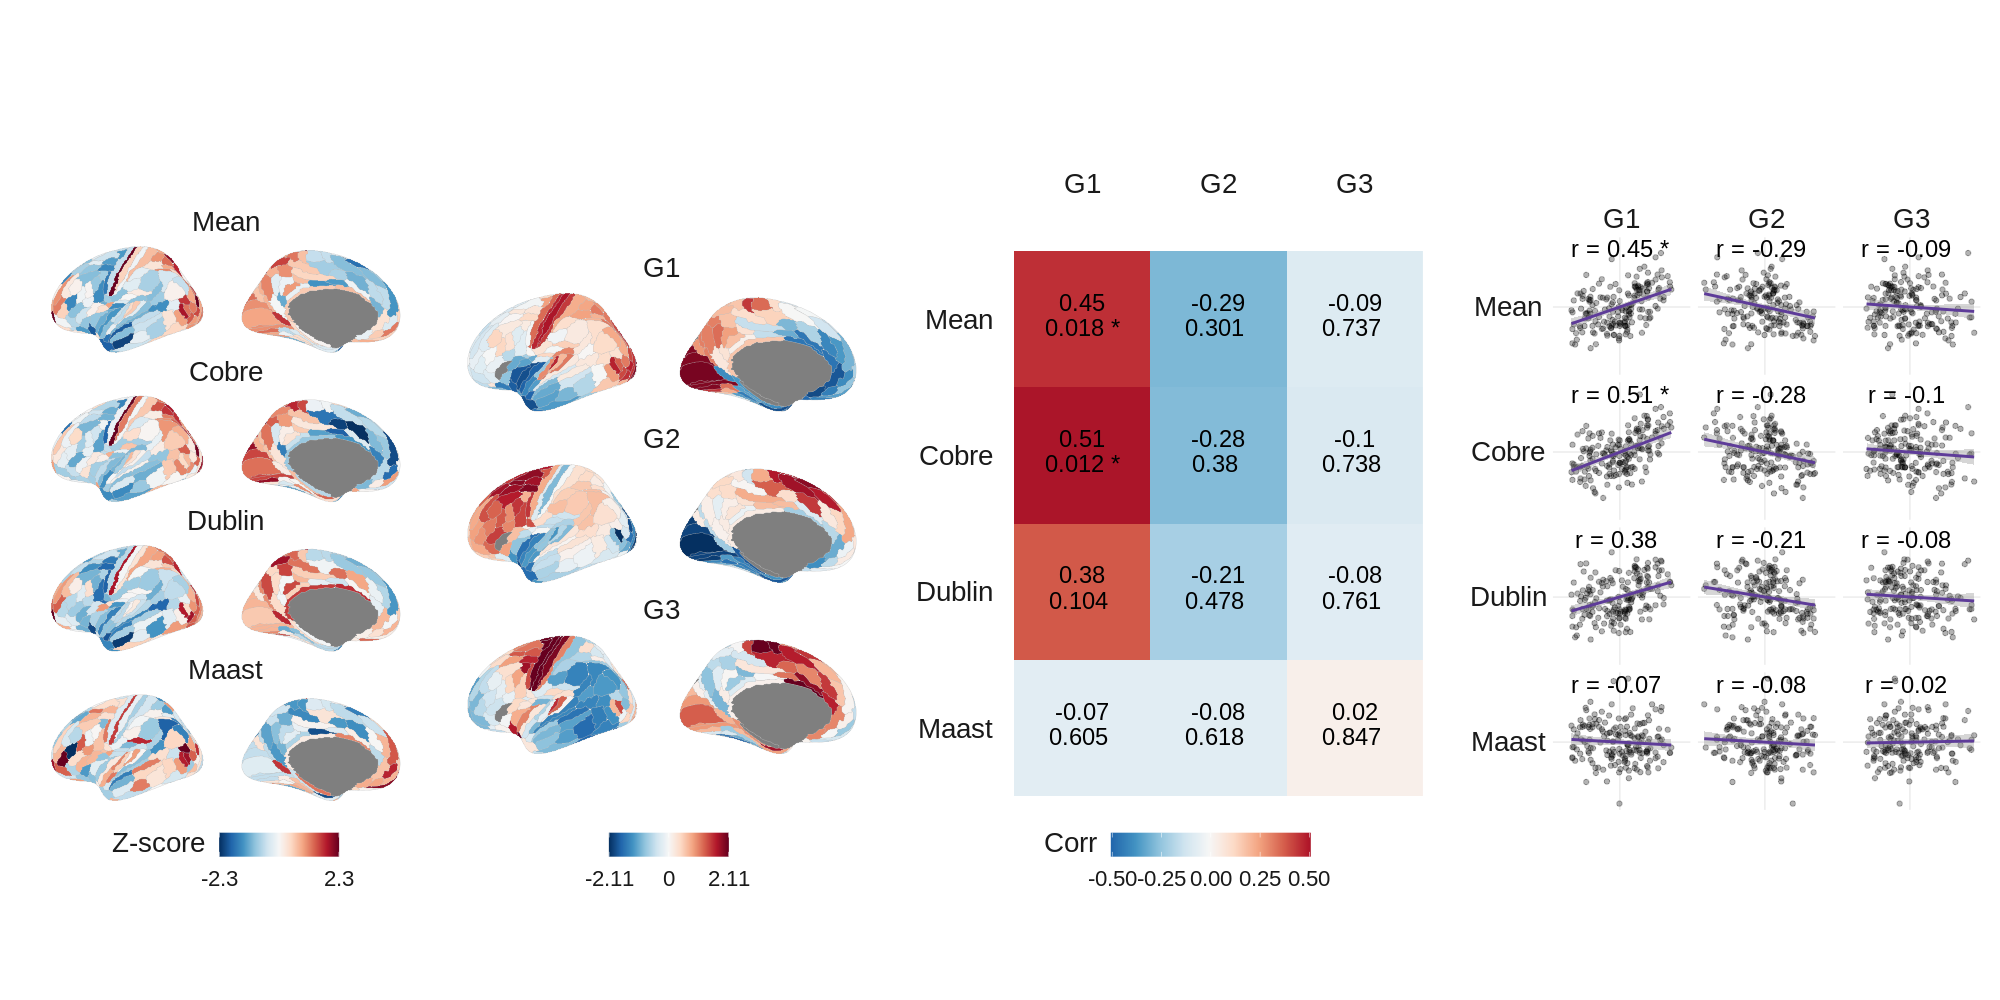

In [67]:
%%R -w 20 -h 10 --units in -r 100 -i scz_fc -i scores -i null_p -i maps_scatter -i maps_scatter_corrs
source("../code/plot_maps.R")
g1 = plot_maps(scz_fc, ncol=1, colors=rev(brewer.rdbu(100)))
g2 = plot_hcp(scores, facet='w')
g3 = plot_corr_versions(null_p %>% mutate(version='')) + scale_x_discrete(position='top') + 
    theme(axis.text=element_text(size=20,color='grey10'))
g4 = plot_maps_scatter(maps_scatter, maps_scatter_corrs %>% mutate(q=p), x=0,y=3,size=6)

(g1 | g2 | g3 | g4) & theme(strip.text=element_text(size=20, color='grey10'),
                            text=element_text(size=20, color='grey10'))